In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.ticker as ticker
import sys
from pathlib import Path
module_path = Path.cwd().parent / 'utils'
sys.path.append(str(module_path))
from simulations import *

# Train on control

## Load datasets

In [2]:
# INDEPENDENT SIMULATED DATASET
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
folder_path = parent_path +  '/dataset/Simulations_aug_indep_traincontrol/'  # change to your folder path
file_names = os.listdir(folder_path)

results_control_indep = []
results_other = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        results_control_indep.append(pd.read_csv(folder_path + name,index_col=0))

    if 'results_survVAE_survival_km_distance' in name:
        results_other.append(pd.read_csv(folder_path + name,index_col=0))

results_control_indep = pd.concat(results_control_indep)
results_control_indep = results_control_indep.sort_values(by='XP_num')
results_other = pd.concat(results_other)
results_other = results_other.sort_values(by='XP_num')
# Identify Surv-VAE columns
survvae_cols = [col for col in results_control_indep.columns if "Surv-VAE" in col]
results_control_indep[survvae_cols] = results_other[survvae_cols].values
for col in results_control_indep.columns:
    results_control_indep[col] = np.float64(results_control_indep[col].values)


# DEPENDENT SIMULATED DATASET
folder_path = parent_path +  '/dataset/Simulations_aug_dep_traincontrol/'  # change to your folder path
file_names = os.listdir(folder_path)

results_control_dep = []
results_other = []
# Display the file names
for name in file_names:
    if 'results_seed11_survival_km_distance' in name:
        results_control_dep.append(pd.read_csv(folder_path + name,index_col=0))

results_control_dep = pd.concat(results_control_dep)
results_control_dep = results_control_dep.sort_values(by='XP_num')
treat_effects_control = np.unique(results_control_dep.H0_coef.values)
aug_percs = np.unique(results_control_dep.aug_perc.values)
for col in results_control_dep.columns:
    results_control_dep[col] = np.float64(results_control_dep[col].values)

## Figures synthcity perf 

- ### metrics : 'J-S distance', 'Survival curves distance', 'K-map score'

In [3]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]

palette = {"Theoritical (original)": "#0072B2", 
           "Theoritical (downsized)": "#009E73",
           'HI-VAE_piecewise' : "#E69F00",  
           'HI-VAE_piecewise_prior': "#F0E442", 
           'HI-VAE_weibull': "#E66101",
           'HI-VAE_weibull_prior': "#ff9896", 
           'Surv-VAE': "#5E3C99", 
           'Surv-GAN': "#CC79A7"}

custom_dashes = {"Theoritical (original)": "", 
           "Theoritical (downsized)": "",
           'HI-VAE_piecewise' : (5,2),  
           'HI-VAE_piecewise_prior': (5,2), 
           'HI-VAE_weibull': (5,2),
           'HI-VAE_weibull_prior': (5,2), 
           'Surv-VAE': (5,2), 
           'Surv-GAN': (5,2)}

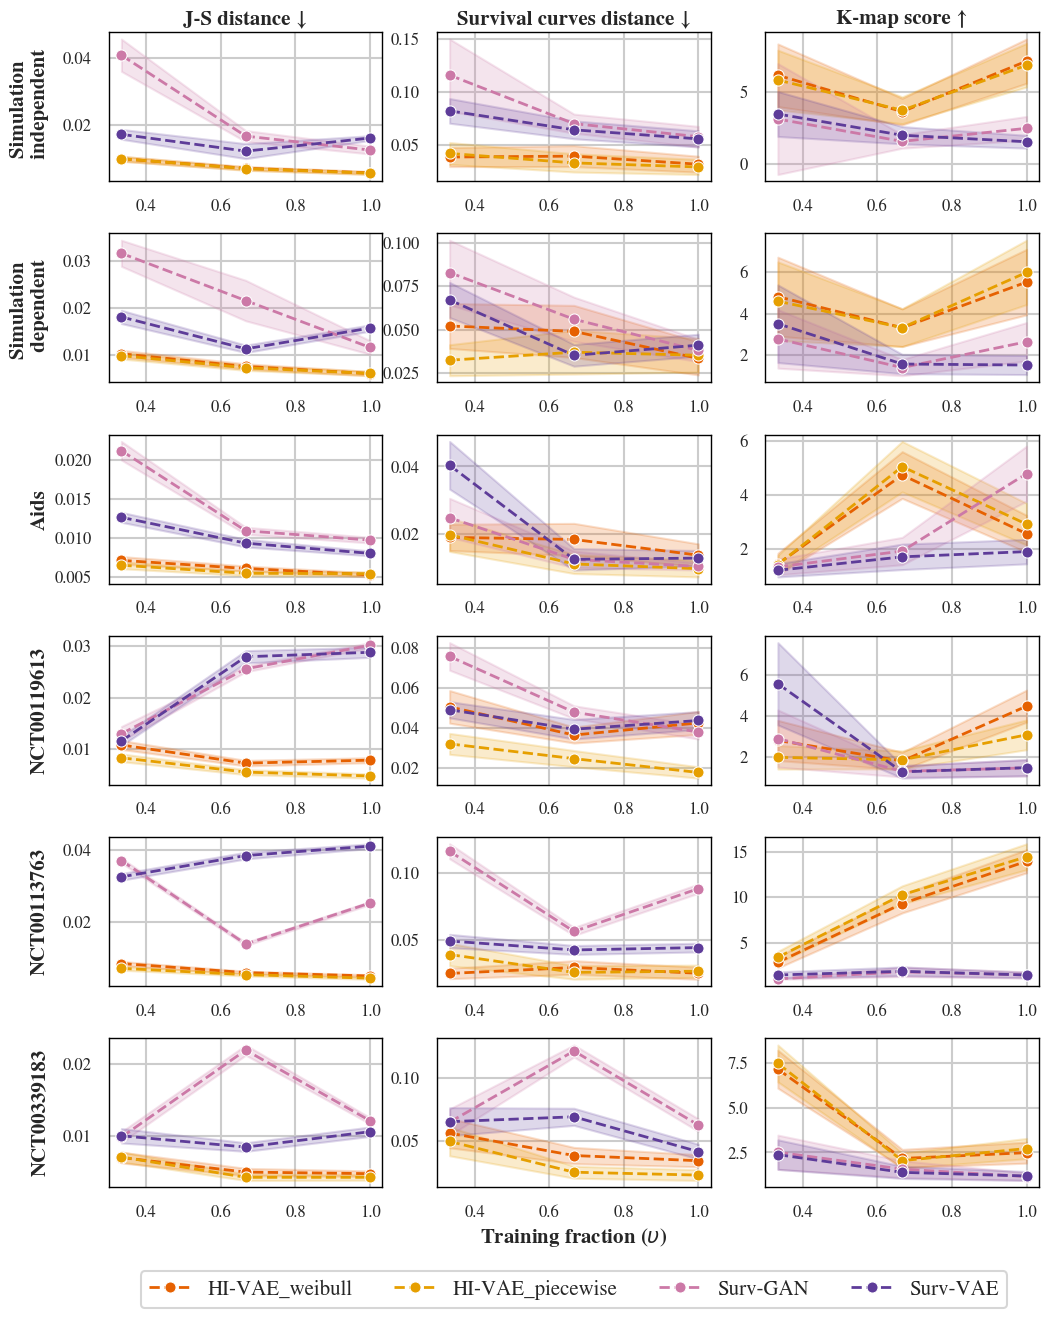

In [4]:
#### SYNTHCITY METRICS
metrics=[['J-S distance', "min"], ['Survival curves distance', "min"], ['K-map score', "max"]]
num_metrics = len(metrics)
n_learners = len(generators_sel)
fig, axs_ = plt.subplots(6, num_metrics, figsize=(4 * len(aug_percs), 2.5 * 6))
plt.subplots_adjust(hspace=.35, wspace=0.2) 

## INDEPENDENT
for j, ax in enumerate(axs_[0]):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    metric_df = pd.DataFrame()
        
    for aug_perc in aug_percs:
        results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                            [aug_perc] * results_ext_control.shape[0],       
                                                            results_ext_control[metric_name + "_" + generator_name].values.astype(float)]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
    metric_df["Augmentation percentage"] = pd.to_numeric(metric_df["Augmentation percentage"], errors="coerce")
    metric_df_ext = metric_df.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    sns.lineplot(data=metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', markersize=8, marker = "o")
    ax.set_xlabel('')

    if j == 0:
        ax.set_ylabel("Simulation \n independent", fontsize=15, fontweight="semibold")
    else:
        ax.set_ylabel('')
    if opt == "max":
        ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
    else:
        ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()

## DEPENDENT

for j, ax in enumerate(axs_[1]):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    metric_df = pd.DataFrame()
        
    for aug_perc in aug_percs:
        results_ext_control = results_control_dep[results_control_dep.aug_perc == aug_perc].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                            [aug_perc] * results_ext_control.shape[0],       
                                                            results_ext_control[metric_name + "_" + generator_name].values.astype(float)]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
    metric_df["Augmentation percentage"] = pd.to_numeric(metric_df["Augmentation percentage"], errors="coerce")
    metric_df_ext = metric_df.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    sns.lineplot(data=metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', markersize=8, marker = "o")
    ax.set_xlabel('')

    if j == 0:
        ax.set_ylabel("Simulation \n dependent", fontsize=15, fontweight="semibold")
    else:
        ax.set_ylabel('')

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()


dataset_names = ["Aids", "SAS_1", "SAS_2", "SAS_3"]
list_n_samples_control = [(1/3), (2/3), 1.0]
for l, axs in enumerate(axs_[2:]):
    res_dir = parent_path +  "/dataset/" + dataset_names[l]
    results_ext = []
    for i in range(len(list_n_samples_control)):
        df_tmp = pd.read_csv(res_dir + '/metric_results/traincontrol_aug_Ncontrol{}%3_general_scores_df.csv'.format((i+1)))
        df_tmp["Augmentation percentage"] = (i+1)/3
        results_ext.append(df_tmp)
    results_ext = pd.concat(results_ext)
    results_ext = results_ext[results_ext.generator.isin(generators_sel)]
    results_ext_ = results_ext.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    results_ext_ = results_ext_[results_ext_.generator.isin(generators_sel)]
    for j, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[j]
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

        sns.lineplot(data=results_ext, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                    linewidth = 2, palette = palette, errorbar = ("sd", .5),
                    linestyle='--', marker = "o", markersize=8)
        if (l == len(dataset_names) - 1) & (j == 1):
            ax.set_xlabel('Training fraction ($\\upsilon$)', fontsize=15, fontweight="semibold")
        else:
            ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        if j == 0:
            if dataset_names[l] == "SAS_1":
                ax.set_ylabel("NCT00119613", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_2":
                ax.set_ylabel("NCT00113763", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_3":
                ax.set_ylabel("NCT00339183", fontsize=15, fontweight="semibold")
            else:
                ax.set_ylabel(dataset_names[l], fontsize=15, fontweight="semibold")
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend().remove()
fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.7, -.88), fontsize=15)
plt.savefig("../figures/datasets_perf_traincontrol_all", bbox_inches="tight")
plt.show()

- ### metrics : 'KS test', 'Detection XGB', 'NNDR'

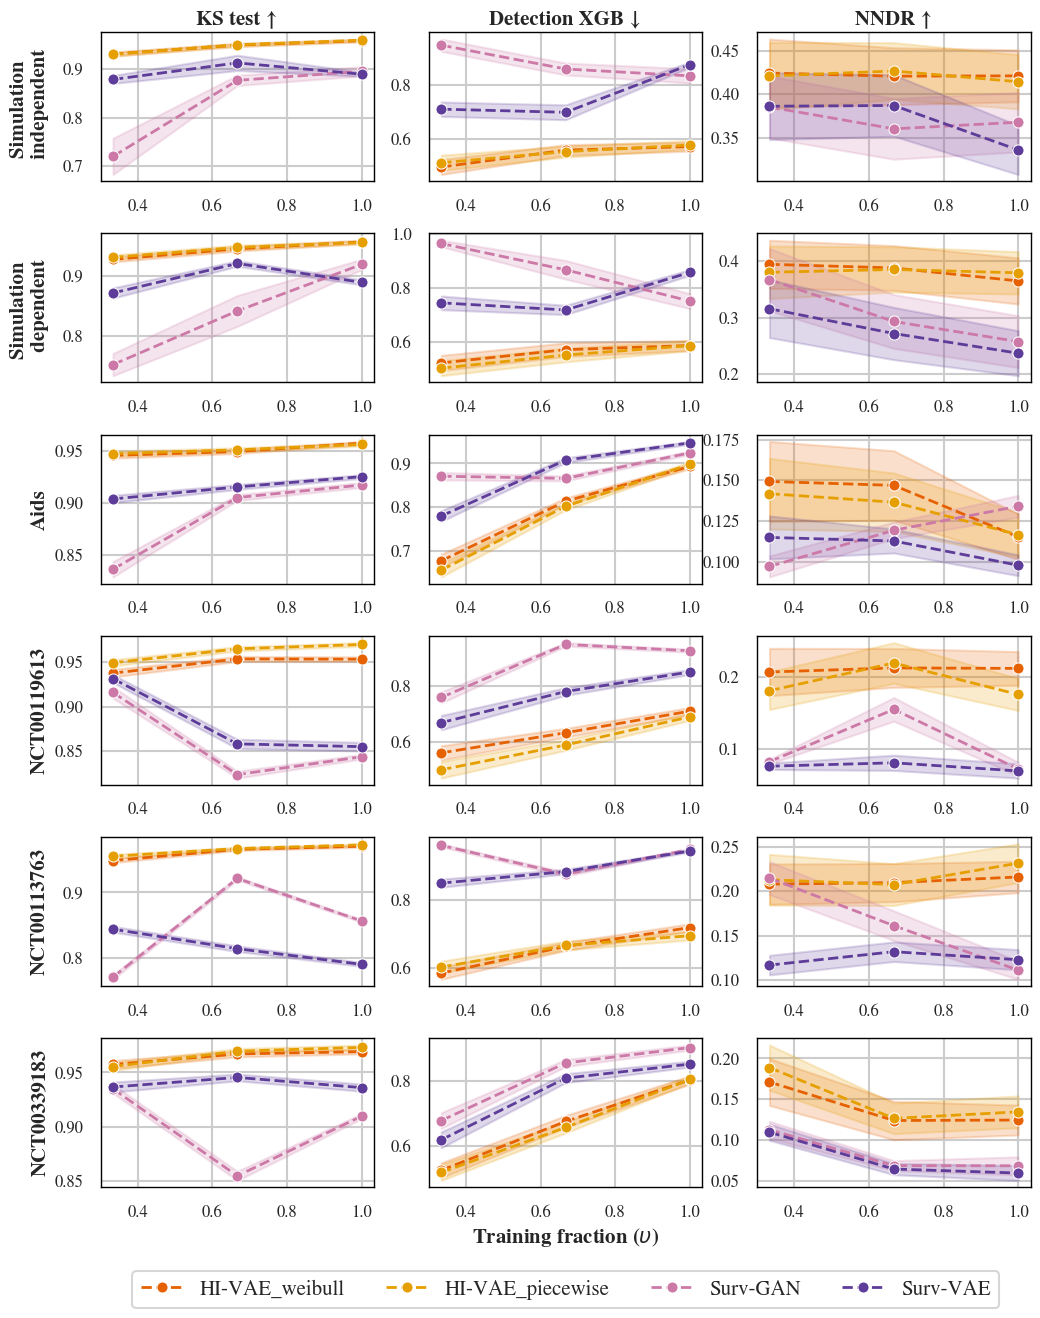

In [5]:
metrics=[['KS test', "max"], ['Detection XGB', "min"], ['NNDR', "max"]]
num_metrics = len(metrics)
fig, axs_ = plt.subplots(6, num_metrics, figsize=(4 * len(aug_percs), 2.5 * 6))
plt.subplots_adjust(hspace=.35, wspace=0.2) 

## INDEPENDENT
for j, ax in enumerate(axs_[0]):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    metric_df = pd.DataFrame()
        
    for aug_perc in aug_percs:
        results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                            [aug_perc] * results_ext_control.shape[0],       
                                                            results_ext_control[metric_name + "_" + generator_name].values.astype(float)]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
    metric_df["Augmentation percentage"] = pd.to_numeric(metric_df["Augmentation percentage"], errors="coerce")
    metric_df_ext = metric_df.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    sns.lineplot(data=metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', markersize=8, marker = "o")
    ax.set_xlabel('')
    if j == 0:
        ax.set_ylabel("Simulation \n independent", fontsize=15, fontweight="semibold")
    else:
        ax.set_ylabel('')
    if opt == "max":
        ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
    else:
        ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()

## DEPENDENT

for j, ax in enumerate(axs_[1]):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    metric_df = pd.DataFrame()
        
    for aug_perc in aug_percs:
        results_ext_control = results_control_dep[results_control_dep.aug_perc == aug_perc].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                            [aug_perc] * results_ext_control.shape[0],       
                                                            results_ext_control[metric_name + "_" + generator_name].values.astype(float)]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
    metric_df["Augmentation percentage"] = pd.to_numeric(metric_df["Augmentation percentage"], errors="coerce")
    metric_df_ext = metric_df.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    sns.lineplot(data=metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', markersize=8, marker = "o")
    ax.set_xlabel('')

    if j == 0:
        ax.set_ylabel("Simulation \n dependent", fontsize=15, fontweight="semibold")
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()

## REAL DATASETS
dataset_names = ["Aids", "SAS_1", "SAS_2", "SAS_3"]
list_n_samples_control = [(1/3), (2/3), 1.0]
for l, axs in enumerate(axs_[2:]):
    res_dir = parent_path +  "/dataset/" + dataset_names[l]
    results_ext = []
    for i in range(len(list_n_samples_control)):
        df_tmp = pd.read_csv(res_dir + '/metric_results/traincontrol_aug_Ncontrol{}%3_general_scores_df.csv'.format((i+1)))
        df_tmp["Augmentation percentage"] = (i+1)/3
        results_ext.append(df_tmp)
    results_ext = pd.concat(results_ext)
    results_ext = results_ext[results_ext.generator.isin(generators_sel)]
    results_ext_ = results_ext.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    results_ext_ = results_ext_[results_ext_.generator.isin(generators_sel)]
    for j, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[j]
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

        sns.lineplot(data=results_ext, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                    linewidth = 2, palette = palette, errorbar = ("sd", .5),
                    linestyle='--', marker = "o", markersize=8)
        if (l == len(dataset_names) - 1) & (j == 1):
            ax.set_xlabel('Training fraction ($\\upsilon$)', fontsize=15, fontweight="semibold")
        else:
            ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        if j == 0:
            if dataset_names[l] == "SAS_1":
                ax.set_ylabel("NCT00119613", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_2":
                ax.set_ylabel("NCT00113763", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_3":
                ax.set_ylabel("NCT00339183", fontsize=15, fontweight="semibold")
            else:
                ax.set_ylabel(dataset_names[l], fontsize=15, fontweight="semibold")
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend().remove()
fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.7, -.88), fontsize=15)
plt.savefig("../figures/datasets_perf_traincontrol_all_sup", bbox_inches="tight")
plt.show()

## Figures Type I error

- ### Indep-Dep / all datasets

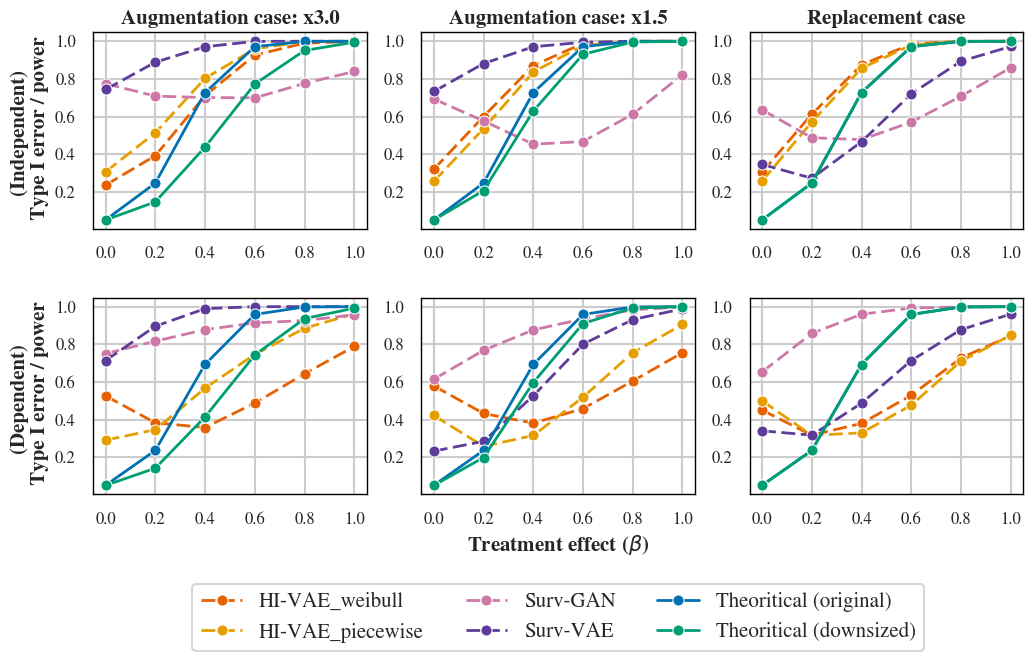

In [6]:

# DEPEDENT

fig, axs = plt.subplots(2, len(aug_percs), figsize=(4 * len(aug_percs), 3 * 2))
plt.subplots_adjust(hspace=.35, wspace=0.2)  

for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[0, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

    for generator_name in generators_sel:
        results_ext_control["reject_H0_gen_" + generator_name] = results_ext_control['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_ext_control.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[0, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[0, i].set_ylabel("")
    axs[0, 0].set_ylabel("(Independent) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[0, i].set_xlabel("")
    if i < len(aug_percs)-1:
        axs[0, i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[0, i].set_title("Replacement case", fontweight="semibold", fontsize=15)
    axs[0, i].legend().remove()
    axs[0, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[0, i].tick_params(axis='x', labelsize=12)
    axs[0, i].tick_params(axis='y', labelsize=12)


for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[1, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_dep[results_control_dep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

    for generator_name in generators_sel:
        results_ext_control["reject_H0_gen_" + generator_name] = results_ext_control['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_ext_control.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    # axs[i].set_ylabel("Level / power")
    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    # print(min(df["Power"].values))
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[1, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[1, i].set_ylabel("")
    axs[1, 0].set_ylabel("(Dependent) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[1, i].set_xlabel("")
    axs[1, 1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15) 
    axs[1, i].legend().remove()
    axs[1, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[1, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[1, i].tick_params(axis='x', labelsize=12)
    axs[1, i].tick_params(axis='y', labelsize=12)
# plt.xlabel("Treatment effect")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.85), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_merge_dep_indep", bbox_inches="tight")
plt.show()

- ### Indep H0 acceptance proportion

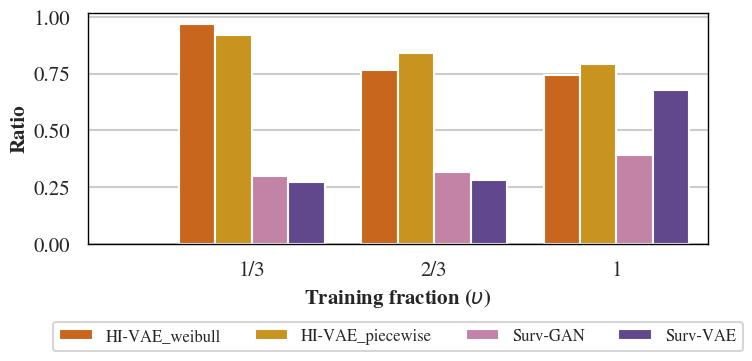

In [7]:
fig = plt.figure(figsize=(8, 3))
# Add one axis (subplot grid: 1 row, 1 column, index 1)
ax = fig.add_subplot(111)

df = pd.DataFrame(columns=["Learner", "Ratio", "Augmentation percentage"])
for i, aug_perc in enumerate(aug_percs):
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)

    custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']

    for generator_name in generators_sel:
        results_ext_control["accept_H0_gen_" + generator_name] = results_ext_control['log_pvalue_control_' + generator_name] < -np.log(0.05)
        # ratio_gen = results_ext_control.groupby("H0_coef").mean()["accept_H0_gen_" + generator_name].to_numpy()
        ratio_gen = results_ext_control["accept_H0_gen_" + generator_name].mean()
        df = pd.concat([df, pd.DataFrame([np.array([generator_name, ratio_gen, aug_perc])], 
                                         columns=["Learner", "Ratio", "Augmentation percentage"])])

df = df.reset_index()
df["Ratio"] = pd.to_numeric(df["Ratio"], errors="coerce")
df["Augmentation percentage"] = pd.to_numeric(df["Augmentation percentage"], errors="coerce")
sns.barplot(data=df, x="Augmentation percentage", y="Ratio", hue="Learner", palette=palette, dodge=True)
ax.set_ylabel("Ratio", fontweight="semibold", fontsize=15)
ax.set_xlabel("Training fraction ($\\upsilon$)", fontweight="semibold", fontsize=15)
ax.set_xticklabels(["1/3", "2/3", "1"])
ax.set_xlim(-.9, 2.5) 
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(.5, -.5), fontsize=12)
plt.savefig("../figures/simu_datasets_traincontrol_ratio_H0", bbox_inches="tight")
plt.show()

- ### Indep - Dep / best generated

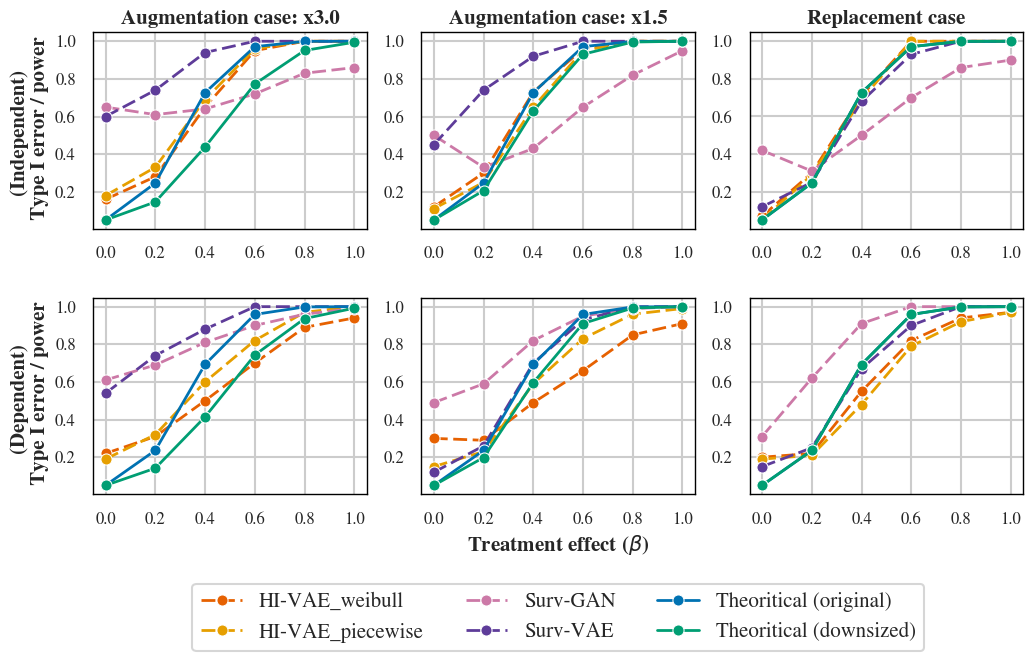

In [8]:
fig, axs = plt.subplots(2, len(aug_percs), figsize=(4 * len(aug_percs), 3 * 2))
plt.subplots_adjust(hspace=.35, wspace=0.2)  
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[0, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    # print(min(df["Power"].values))
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[0, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[0, i].set_ylabel("")
    axs[0, 0].set_ylabel("(Independent) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[0, i].set_xlabel("")
    if i < len(aug_percs)-1:
        axs[0, i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[0, i].set_title("Replacement case", fontweight="semibold", fontsize=15)
    # plt.legend()    
    axs[0, i].legend().remove()
    axs[0, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[0, i].tick_params(axis='x', labelsize=12)
    axs[0, i].tick_params(axis='y', labelsize=12)


# DEP
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[1, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_dep[results_control_dep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[1, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[1, i].set_ylabel("")
    axs[1, 0].set_ylabel("(Dependent) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[1, i].set_xlabel("")
    axs[1, 1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
    axs[1, i].legend().remove()
    axs[1, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[1, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[1, i].tick_params(axis='x', labelsize=12)
    axs[1, i].tick_params(axis='y', labelsize=12)
# plt.xlabel("Treatment effect")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.85), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_best_gen_merge_indep_dep", bbox_inches="tight")
plt.show()

- ### Indep - Dep / best 40 generated

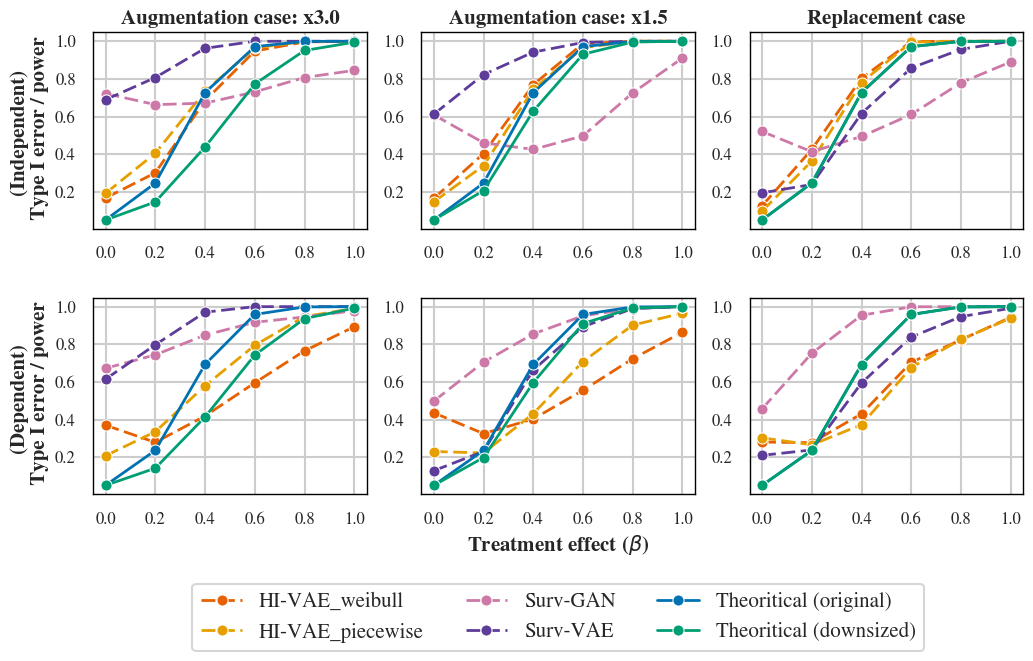

In [9]:
fig, axs = plt.subplots(2, len(aug_percs), figsize=(4 * len(aug_percs), 3 * 2))
plt.subplots_adjust(hspace=.35, wspace=0.2)  
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[0, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()
    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            results_MC_best = results_MC.nsmallest(40, "log_pvalue_control_" + generator_name).copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[0, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[0, i].set_ylabel("")
    axs[0, 0].set_ylabel("(Independent) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[0, i].set_xlabel("")
    if i < len(aug_percs)-1:
        axs[0, i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[0, i].set_title("Replacement case", fontweight="semibold", fontsize=15)
    # plt.legend()    
    axs[0, i].legend().remove()
    axs[0, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[0, i].tick_params(axis='x', labelsize=12)
    axs[0, i].tick_params(axis='y', labelsize=12)


for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[1, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_dep[results_control_dep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()
    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            results_MC_best = results_MC.nsmallest(40, "log_pvalue_control_" + generator_name).copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[1, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[1, i].set_ylabel("")
    axs[1, 0].set_ylabel("(Dependent) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[1, i].set_xlabel("")
    axs[1, 1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
    axs[1, i].legend().remove()
    axs[1, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[1, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[1, i].tick_params(axis='x', labelsize=12)
    axs[1, i].tick_params(axis='y', labelsize=12)

plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.85), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_best_gen_40_merge_indep_dep", bbox_inches="tight")
plt.show()

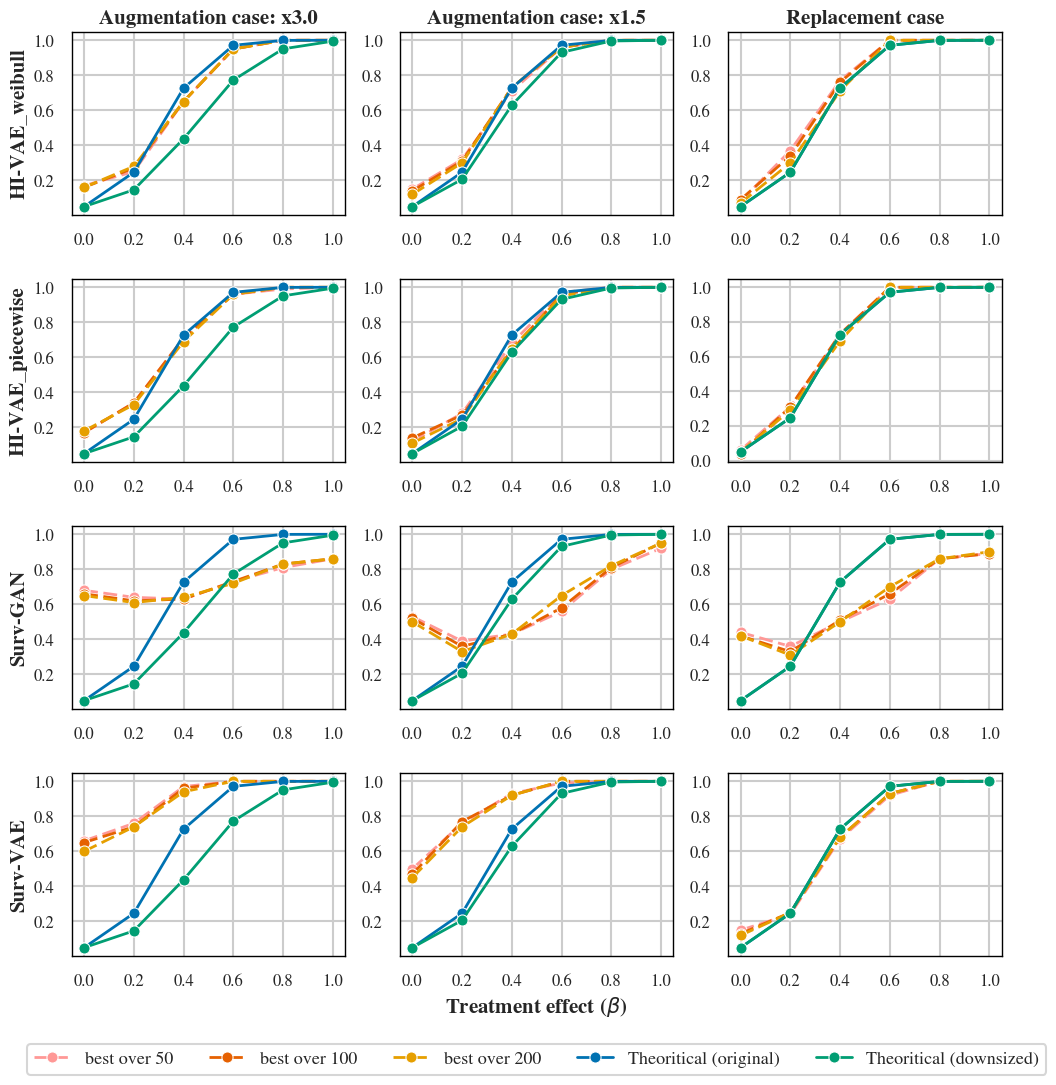

In [10]:
fig, axs_ = plt.subplots(len(generators_sel), len(aug_percs), figsize=(4 * len(aug_percs), 3 * len(generators_sel)))
plt.subplots_adjust(hspace=.35, wspace=0.2)  

palette.update({'best over 50': "#ff9896", 
           'best over 100': "#E66101", 
           'best over 200': "#E69F00"})

custom_dashes.update({'best over 50': (5, 2), 
           'best over 100': (5, 2), 
           'best over 200': (5, 2)})

for k, generator_name in enumerate(generators_sel):
    axs = axs_[k]
    for i, aug_perc in enumerate(aug_percs):
        df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
        for spine in axs[i].spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')
        results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
        H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
        D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
        D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

        custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
        XP_num = np.unique(results_ext_control["XP_num"].values)
        for num_gen_sel in [50, 100, 200]:
            results_MC_best_list = []
            for m in XP_num:
                results_MC = results_ext_control[results_ext_control["XP_num"] == m]
                best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values[:num_gen_sel])
                results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
                results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
                results_MC_best_list.append(results_MC_best)
            power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
            df = pd.concat([df, pd.DataFrame(np.array([["best over {}".format(num_gen_sel)] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                            columns=["Learner", "Treatment effect", "Power"])])
        power_theo = []
        power_theo_init = []
        for j in range(len(H0_coef_univ_theo)):
            power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
            power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

        df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                        columns=["Learner", "Treatment effect", "Power"])])
        
        df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                        columns=["Learner", "Treatment effect", "Power"])])

        df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
        df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
        sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                            linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
        if i == 0:
            axs[i].set_ylabel(generator_name, fontweight="semibold", fontsize=15)
        else:
            axs[i].set_ylabel("")
        axs[i].set_xlabel("")
        if k == len(generators_sel) - 1:
            axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
        if k == 0:
            if i < len(aug_percs)-1:
                axs[i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
            else: 
                axs[i].set_title("Replacement case", fontweight="semibold", fontsize=15)  
        axs[i].legend().remove()
        axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
        axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
        axs[i].tick_params(axis='x', labelsize=12)
        axs[i].tick_params(axis='y', labelsize=12)

plt.legend(ncol=5, loc="lower center", bbox_to_anchor=(-.7, -.7), fontsize=13)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_best_gen_sup", bbox_inches="tight")
plt.show()

### Prior vs Posterior

In [11]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "HI-VAE_weibull_prior", "HI-VAE_piecewise_prior"]

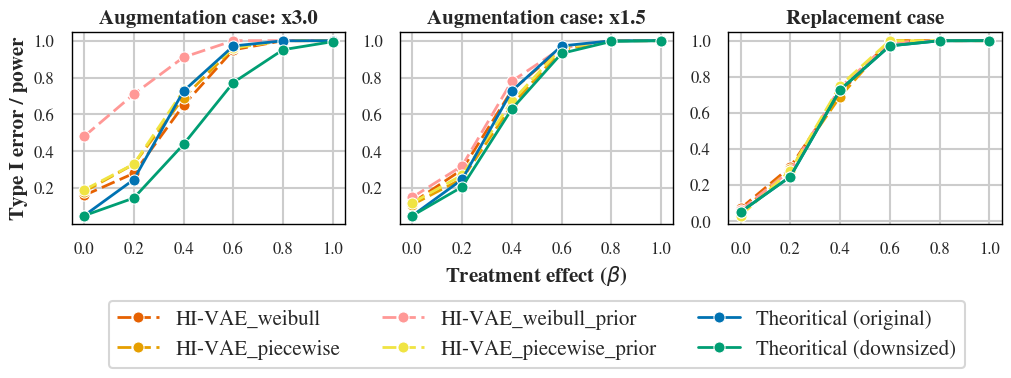

In [12]:
aug_percs = np.unique(results_control_indep.aug_perc.values)
fig, axs = plt.subplots(1, len(aug_percs), figsize=(4 * len(aug_percs), 2.5))
plt.subplots_adjust(hspace=.35, wspace=0.2)
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

    custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[i].set_ylabel("")
    axs[0].set_ylabel("Type I error / power", fontweight="semibold", fontsize=15)
    axs[i].set_xlabel("")
    axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
    if i < len(aug_percs)-1:
        axs[i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[i].set_title("Replacement case", fontweight="semibold", fontsize=15)

    axs[i].legend().remove()
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)

plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.8), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_best_gen_merge_prior_posterior", bbox_inches="tight")
plt.show()

## Train on control vs Control + Treated

- ### Load datasets

In [13]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
folder_path = parent_path + '/dataset/Simulations_aug_indep_trainfull/'  # change to your folder path
file_names = os.listdir(folder_path)
results_trainfull_1 = []
results_trainfull_2 = []
results_trainfull_3 = []
results_trainfull_08 = []
results_trainfull_10 = []
results_logrank = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        results_trainfull_1.append(pd.read_csv(folder_path + name,index_col=0))
    elif 'results_2_survival_km_distance' in name:
        results_trainfull_2.append(pd.read_csv(folder_path + name,index_col=0))
    elif 'results_treateffect_0.8' in name:
        results_trainfull_08.append(pd.read_csv(folder_path + name,index_col=0))
    elif 'results_treateffect_1.0' in name:
        results_trainfull_10.append(pd.read_csv(folder_path + name,index_col=0))
results_trainfull_1 = pd.concat(results_trainfull_1)
results_trainfull_1 = results_trainfull_1.sort_values(by='XP_num')
results_trainfull_2 = pd.concat(results_trainfull_2)
results_trainfull_2 = results_trainfull_2.sort_values(by='XP_num')
results_trainfull_08 = pd.concat(results_trainfull_08)
results_trainfull_08 = results_trainfull_08.sort_values(by='XP_num')
results_trainfull_10 = pd.concat(results_trainfull_10)
results_trainfull_10 = results_trainfull_10.sort_values(by='XP_num')

treat_effects_trainfull_1 = np.unique(results_trainfull_1.H0_coef.values)
treat_effects_trainfull_2 = np.unique(results_trainfull_2.H0_coef.values)
treat_effects_trainfull_08 = np.unique(results_trainfull_08.H0_coef.values)
treat_effects_trainfull_10 = np.unique(results_trainfull_10.H0_coef.values)
aug_percs = np.unique(results_trainfull_1.aug_perc.values)
for col in results_trainfull_1.columns:
    results_trainfull_1[col] = np.float64(results_trainfull_1[col].values)

results_trainfull_2["XP_num"] = results_trainfull_2.XP_num + results_trainfull_1.XP_num.max() + 1
results_trainfull_08["XP_num"] = results_trainfull_08.XP_num + results_trainfull_2.XP_num.max() + 1
results_trainfull_10["XP_num"] = results_trainfull_10.XP_num + results_trainfull_08.XP_num.max() + 1
results_trainfull = pd.concat([results_trainfull_1, results_trainfull_2, results_trainfull_08, results_trainfull_10])
results_trainfull = results_trainfull.sort_values(by='H0_coef')
treat_effects_trainfull = np.unique(results_trainfull.H0_coef.values)

treat_effects_control = np.unique(results_trainfull.H0_coef.values)
aug_percs = np.unique(results_trainfull.aug_perc.values)
for col in results_trainfull.columns:
    results_trainfull[col] = np.float64(results_trainfull[col].values)

- ### Figure Type I error

- ### Best generated dataset

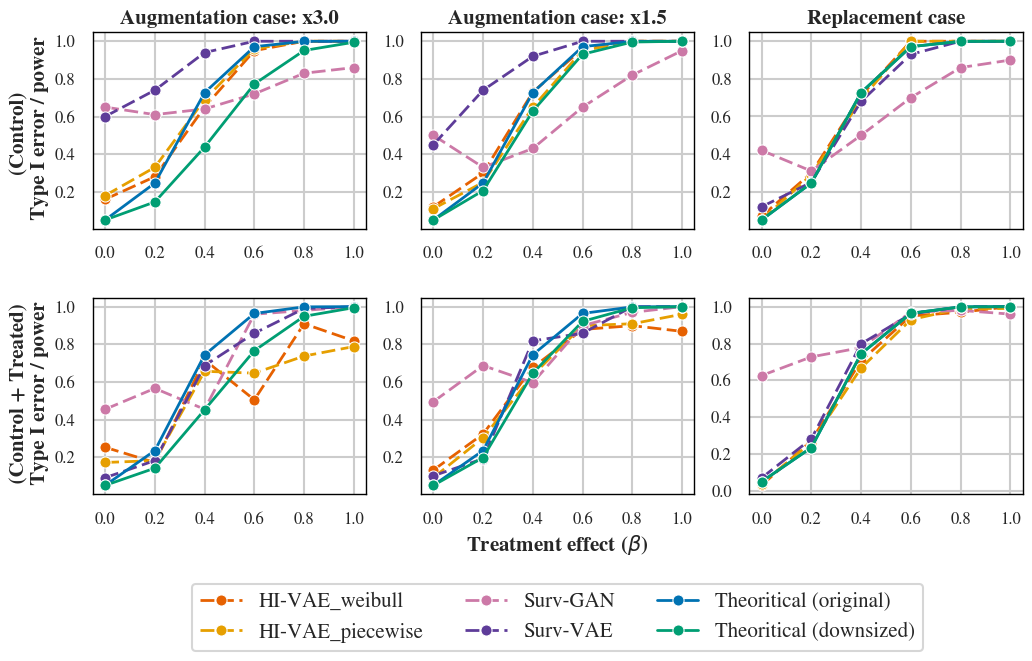

In [14]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]

aug_percs = np.unique(results_control_dep.aug_perc.values)
fig, axs = plt.subplots(2, len(aug_percs), figsize=(4 * len(aug_percs), 3 * 2))
plt.subplots_adjust(hspace=.35, wspace=0.2)  
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[0, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[0, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[0, i].set_ylabel("")
    axs[0, 0].set_ylabel("(Control) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[0, i].set_xlabel("")
    if i < len(aug_percs)-1:
        axs[0, i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[0, i].set_title("Replacement case", fontweight="semibold", fontsize=15)
    # plt.legend()    
    axs[0, i].legend().remove()
    axs[0, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[0, i].tick_params(axis='x', labelsize=12)
    axs[0, i].tick_params(axis='y', labelsize=12)

# Train full
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[1, i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_trainfull[results_trainfull.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    power_theo = []
    power_theo_init = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
        power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[1, i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[1, i].set_ylabel("")
    axs[1, 0].set_ylabel("  (Control + Treated) \n Type I error / power", fontweight="semibold", fontsize=15)
    axs[1, i].set_xlabel("")
    axs[1, 1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
    axs[1, i].legend().remove()
    axs[1, i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[1, i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[1, i].tick_params(axis='x', labelsize=12)
    axs[1, i].tick_params(axis='y', labelsize=12)

plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.85), fontsize=15)
plt.savefig("../figures/simu_datasets_p_value_best_gen_merge_control_full", bbox_inches="tight")
plt.show()

# Appendix

## Selection of best generated dataset

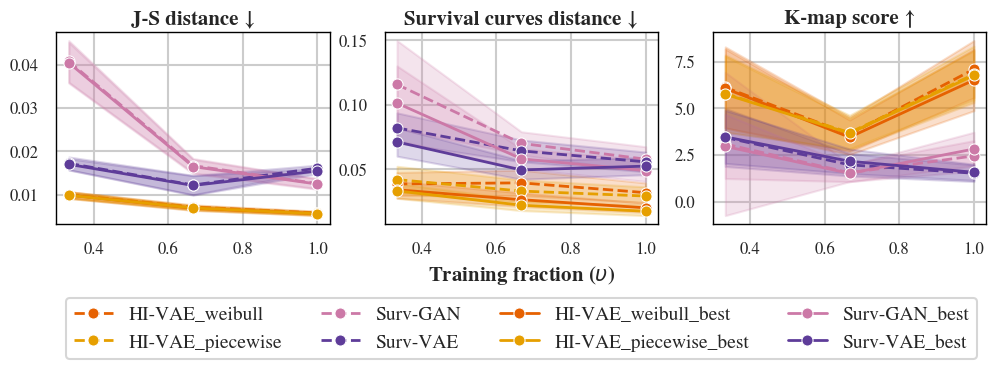

In [15]:
metrics=[['J-S distance', "min"], ['Survival curves distance', "min"], ['K-map score', "max"]]
aug_percs = np.unique(results_control_indep.aug_perc.values)
#### SYNTHCITY METRICS
num_metrics = len(metrics)
n_learners = len(generators_sel)
fig, axs = plt.subplots(1, num_metrics, figsize=(4 * len(aug_percs), 2.5))
plt.subplots_adjust(hspace=.35, wspace=0.2) 

for j, ax in enumerate(axs):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    metric_df = pd.DataFrame()
    best_metric_df = pd.DataFrame()
        
    for aug_perc in aug_percs:
        results_ext_control = results_control_indep[results_control_indep.aug_perc == aug_perc].copy(deep=True)

        XP_num = np.unique(results_ext_control["XP_num"].values)
        for generator_name in generators_sel:
            results_MC_best_list = []
            for m in XP_num:
                results_MC = results_ext_control[results_ext_control["XP_num"] == m]
                best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
                results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
                results_MC_best_list.append(results_MC_best)
            tmp = pd.concat(results_MC_best_list)[metric_name + "_" + generator_name].values.astype(float)
            best_metric_df = pd.concat([best_metric_df, pd.DataFrame(np.array([[generator_name] * len(tmp),
                                                            [aug_perc]  * len(tmp), tmp]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
                                                   
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                            [aug_perc] * results_ext_control.shape[0],       
                                                            results_ext_control[metric_name + "_" + generator_name].values.astype(float)]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
    

    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
    metric_df["Augmentation percentage"] = pd.to_numeric(metric_df["Augmentation percentage"], errors="coerce")
    best_metric_df[metric_name] = pd.to_numeric(best_metric_df[metric_name], errors="coerce")
    best_metric_df["Augmentation percentage"] = pd.to_numeric(best_metric_df["Augmentation percentage"], errors="coerce")

    best_metric_df["generator"] = best_metric_df["generator"].replace({"HI-VAE_weibull": "HI-VAE_weibull_best", 
                                                                           "HI-VAE_piecewise": "HI-VAE_piecewise_best",
                                                                           'Surv-VAE': 'Surv-VAE_best',
                                                                           'Surv-GAN' : 'Surv-GAN_best'})
    palette["HI-VAE_weibull_best"] = palette["HI-VAE_weibull"]
    palette["HI-VAE_piecewise_best"] = palette["HI-VAE_piecewise"]
    palette["Surv-VAE_best"] = palette["Surv-VAE"]
    palette["Surv-GAN_best"] = palette["Surv-GAN"]

    sns.lineplot(data=metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', marker = "o", markersize=8)
    sns.lineplot(data=best_metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), marker = "o", markersize=8)

    if j == 1:
        ax.set_xlabel('Training fraction ($\\upsilon$)', fontsize=15, fontweight="semibold")
    else:
        ax.set_xlabel('')
    ax.set_ylabel('')
    if opt == "max":
        ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
    else:
        ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()

fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.7, -.75), fontsize=14)
plt.savefig("../figures/simu_datasets_traincontrol_perf_compare", bbox_inches="tight")
plt.show()

## Hyperopt

In [16]:
generators_sel = ["HI-VAE_piecewise", "Surv-VAE"]

- ### Load results datasets

In [17]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
folder_path = parent_path +  '/dataset/Simulations_aug_indep_traincontrol/'  # change to your folder path
file_names = os.listdir(folder_path)

results_control_seed10_method1 = []
results_other = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        results_control_seed10_method1.append(pd.read_csv(folder_path + name,index_col=0))
    if 'results_survVAE_survival_km_distance' in name:
        results_other.append(pd.read_csv(folder_path + name,index_col=0))

results_control_seed10_method1 = pd.concat(results_control_seed10_method1)
results_control_seed10_method1 = results_control_seed10_method1.sort_values(by='XP_num')
results_other = pd.concat(results_other)
results_other = results_other.sort_values(by='XP_num')
# Identify Surv-VAE columns
survvae_cols = [col for col in results_control_seed10_method1.columns if "Surv-VAE" in col]
results_control_seed10_method1[survvae_cols] = results_other[survvae_cols].values
for col in results_control_seed10_method1.columns:
    results_control_seed10_method1[col] = np.float64(results_control_seed10_method1[col].values)


results_control_seed10_method2 = []
# Display the file names
for name in file_names:
    if 'results_method2_survival_km_distance' in name:
        results_control_seed10_method2.append(pd.read_csv(folder_path + name,index_col=0))
results_control_seed10_method2 = pd.concat(results_control_seed10_method2)
results_control_seed10_method2 = results_control_seed10_method2.sort_values(by='XP_num')

treat_effects_control = np.unique(results_control_seed10_method2.H0_coef.values)
aug_percs = np.unique(results_control_seed10_method2.aug_perc.values)
for col in results_control_seed10_method2.columns:
    results_control_seed10_method2[col] = np.float64(results_control_seed10_method2[col].values)

results_control_seed10_method3 = []
# Display the file names
for name in file_names:
    if 'results_method3_survival_km_distance' in name:
        results_control_seed10_method3.append(pd.read_csv(folder_path + name,index_col=0))
results_control_seed10_method3 = pd.concat(results_control_seed10_method3)
results_control_seed10_method3 = results_control_seed10_method3.sort_values(by='XP_num')
for col in results_control_seed10_method3.columns:
    results_control_seed10_method3[col] = np.float64(results_control_seed10_method3[col].values)

results_control_seed11_method1 = []
# Display the file names
for name in file_names:
    if 'results_seed11_survival_km_distance' in name:
        results_control_seed11_method1.append(pd.read_csv(folder_path + name,index_col=0))
results_control_seed11_method1 = pd.concat(results_control_seed11_method1)
results_control_seed11_method1 = results_control_seed11_method1.sort_values(by='XP_num')
for col in results_control_seed11_method1.columns:
    results_control_seed11_method1[col] = np.float64(results_control_seed11_method1[col].values)

results_control_seed12_method1 = []
# Display the file names
for name in file_names:
    if 'results_seed12_survival_km_distance' in name:
        results_control_seed12_method1.append(pd.read_csv(folder_path + name,index_col=0))
results_control_seed12_method1 = pd.concat(results_control_seed12_method1)
results_control_seed12_method1 = results_control_seed12_method1.sort_values(by='XP_num')
for col in results_control_seed12_method1.columns:
    results_control_seed12_method1[col] = np.float64(results_control_seed12_method1[col].values)

- ### hyperopt methods

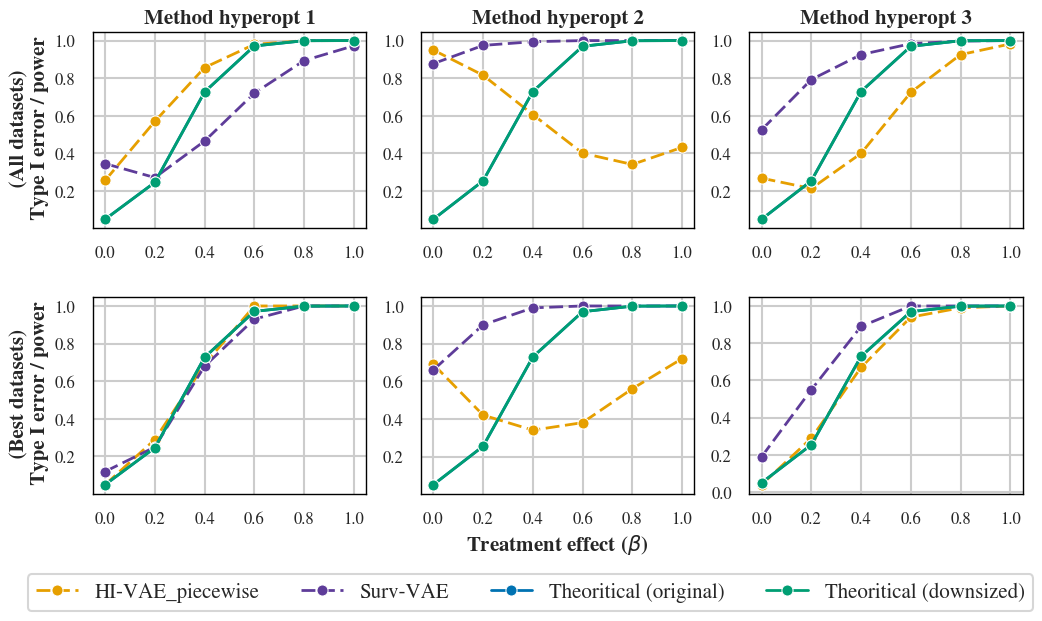

In [18]:
fig, axs_ = plt.subplots(2, 3, figsize=(4 * 3, 2 * 3))
plt.subplots_adjust(hspace=.35, wspace=0.2)  

results_df_list_method = [results_control_seed10_method1, results_control_seed10_method2, results_control_seed10_method3]
name_methods = ["Method hyperopt 1", "Method hyperopt 2", "Method hyperopt 3"]
results_df_list_seed = [results_control_seed10_method1, results_control_seed11_method1, results_control_seed12_method1]
name_seeds = ["Seed 10", "Seed 11", "Seed 12"]

results_df_list = results_df_list_method  # or results_df_list_seed
name_list = name_methods  # or name_seeds

for k, axs in enumerate(axs_):
    
    for i, results_control in enumerate(results_df_list):
        df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
        for spine in axs[i].spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')
        results_ext_control = results_control[results_control.aug_perc == aug_percs[0]].copy(deep=True)
        H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
        D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
        D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

        if k == 0:
            for generator_name in generators_sel:
                results_ext_control["reject_H0_gen_" + generator_name] = results_ext_control['log_pvalue_' + generator_name] > -np.log(0.05)
                power_gen = results_ext_control.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
                df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                                columns=["Learner", "Treatment effect", "Power"])])
        else:
            custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
            XP_num = np.unique(results_ext_control["XP_num"].values)
            for generator_name in generators_sel:
                results_MC_best_list = []
                for m in XP_num:
                    results_MC = results_ext_control[results_ext_control["XP_num"] == m]
                    best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
                    results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
                    results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
                    results_MC_best_list.append(results_MC_best)
                power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
                df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                                columns=["Learner", "Treatment effect", "Power"])])

        power_theo = []
        power_theo_init = []
        for j in range(len(H0_coef_univ_theo)):
            power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
            power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

        df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                        columns=["Learner", "Treatment effect", "Power"])])
        
        df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                        columns=["Learner", "Treatment effect", "Power"])])

        df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
        df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
        sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                            linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
        axs[i].set_ylabel("")
        if k == 0:
            axs[0].set_ylabel("  (All datasets) \n Type I error / power", fontweight="semibold", fontsize=15)

        if k == 1:
            axs[0].set_ylabel("  (Best datasets) \n Type I error / power", fontweight="semibold", fontsize=15)
        axs[i].set_xlabel("")
        if k == 1:
            axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
        if k == 0:
            axs[i].set_title(name_list[i], fontweight="semibold", fontsize=15)
        axs[i].legend().remove()
        axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
        axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
        axs[i].tick_params(axis='x', labelsize=12)
        axs[i].tick_params(axis='y', labelsize=12)


plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.8, -.65), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_methods_hyperopt_allbest", bbox_inches="tight")
plt.show()

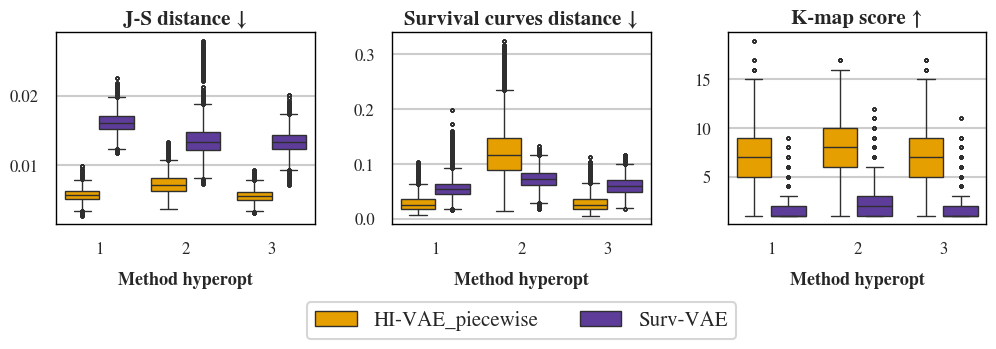

In [19]:
metrics=[['J-S distance', "min"], 
         ['Survival curves distance', "min"], 
         ['K-map score', "max"]]

#### SYNTHCITY METRICS
num_metrics = len(metrics)
n_learners = len(generators_sel)

results_df_list = results_df_list_method  # or results_df_list_seed
name_list = name_methods  # or name_seeds

fig, axs_ = plt.subplots(1, num_metrics, figsize=(4 * 3, 2.5 * 1))
plt.subplots_adjust(hspace=.35, wspace=0.3) 

for j, ax in enumerate(axs_):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    metric_df = pd.DataFrame()
        
    for i, results_control in enumerate(results_df_list):
        results_ext_control = results_control[results_control.aug_perc == aug_percs[0]].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, 
                                   pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                           [i+1] * results_ext_control.shape[0],       
                                                           results_ext_control[metric_name + "_" + generator_name].values.astype(float)]
                                                         ).T,
                                                columns=['generator', "method", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")

    sns.boxplot(data=metric_df, 
                x="method", 
                y=metric_name, 
                hue="generator", 
                ax=ax, 
                palette=palette,
                showcaps=True,
                fliersize=2, 
                linewidth=1, 
                saturation=1)

    ax.set_xlabel("Method hyperopt", fontsize=13, fontweight="semibold", labelpad=10)

    # if j == 0:
    #     ax.set_ylabel("Simulation", fontsize=15, fontweight="semibold")
    # else:
    ax.set_ylabel('')

    if opt == "max":
        ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
    else:
        ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()

fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.8, -.65), fontsize=15)
plt.savefig("../figures/datasets_perf_traincontrol_method_hyperopt", bbox_inches="tight")
plt.show()


- ### Seed

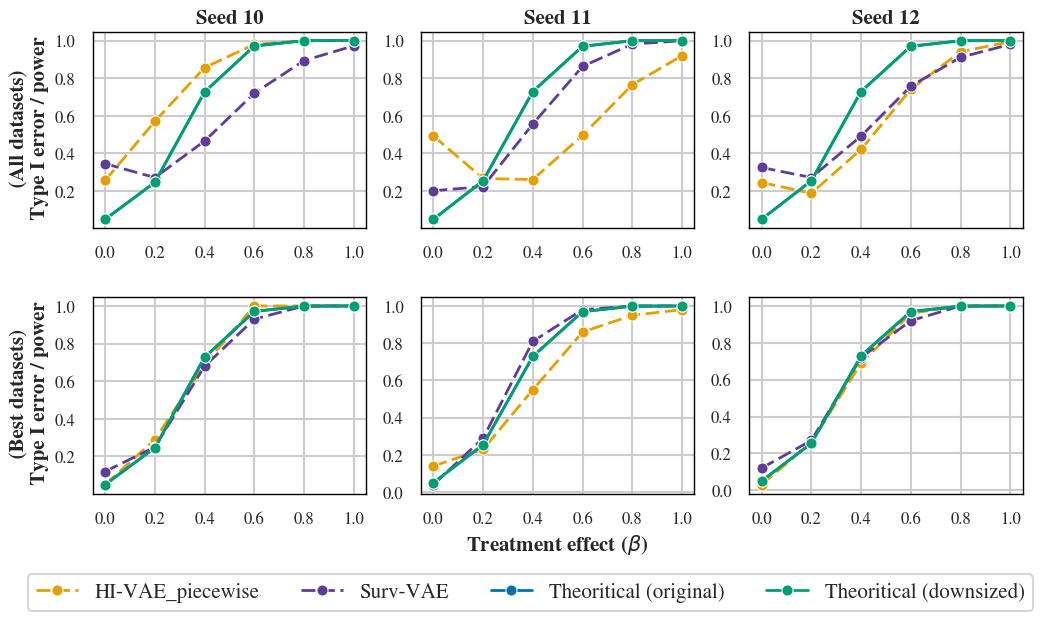

In [20]:
fig, axs_ = plt.subplots(2, 3, figsize=(4 * 3, 2 * 3))
plt.subplots_adjust(hspace=.35, wspace=0.2)  

results_df_list_method = [results_control_seed10_method1, results_control_seed10_method2, results_control_seed10_method3]
name_methods = ["Method hyperopt 1", "Method hyperopt 2", "Method hyperopt 3"]
results_df_list_seed = [results_control_seed10_method1, results_control_seed11_method1, results_control_seed12_method1]
name_seeds = ["Seed 10", "Seed 11", "Seed 12"]

results_df_list = results_df_list_seed
name_list = name_seeds

for k, axs in enumerate(axs_):
    
    for i, results_control in enumerate(results_df_list):
        df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
        for spine in axs[i].spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')
        results_ext_control = results_control[results_control.aug_perc == aug_percs[0]].copy(deep=True)
        H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
        D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
        D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

        custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
        if k == 0:
            for generator_name in generators_sel:
                results_ext_control["reject_H0_gen_" + generator_name] = results_ext_control['log_pvalue_' + generator_name] > -np.log(0.05)
                power_gen = results_ext_control.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
                df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                                columns=["Learner", "Treatment effect", "Power"])])
        else:
            custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
            XP_num = np.unique(results_ext_control["XP_num"].values)
            for generator_name in generators_sel:
                results_MC_best_list = []
                for m in XP_num:
                    results_MC = results_ext_control[results_ext_control["XP_num"] == m]
                    best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
                    results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
                    results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
                    results_MC_best_list.append(results_MC_best)
                power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
                df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                                columns=["Learner", "Treatment effect", "Power"])])

        power_theo = []
        power_theo_init = []
        for j in range(len(H0_coef_univ_theo)):
            power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
            power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

        df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                        columns=["Learner", "Treatment effect", "Power"])])
        
        df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                        columns=["Learner", "Treatment effect", "Power"])])

        df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
        df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
        sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                            linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
        axs[i].set_ylabel("")
        if k == 0:
            axs[0].set_ylabel("  (All datasets) \n Type I error / power", fontweight="semibold", fontsize=15)

        if k == 1:
            axs[0].set_ylabel("  (Best datasets) \n Type I error / power", fontweight="semibold", fontsize=15)
        axs[i].set_xlabel("")
        if k == 1:
            axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
        if k == 0:
            axs[i].set_title(name_list[i], fontweight="semibold", fontsize=15)
        axs[i].legend().remove()
        axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
        axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
        axs[i].tick_params(axis='x', labelsize=12)
        axs[i].tick_params(axis='y', labelsize=12)

plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.8, -.65), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_seed_hyperopt_allbest", bbox_inches="tight")
plt.show()

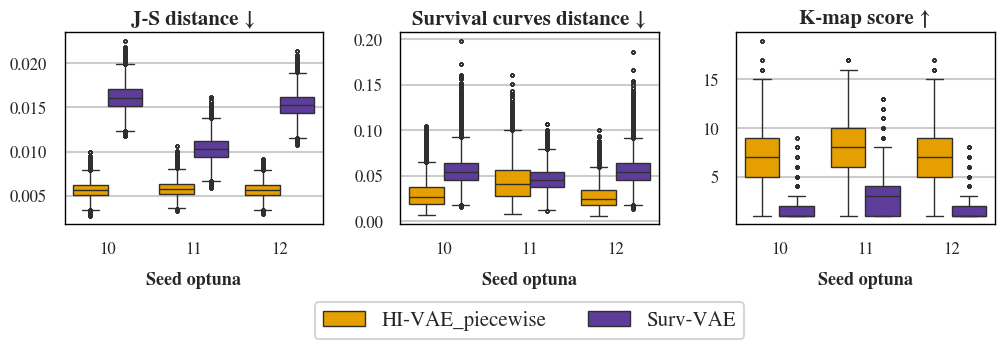

In [21]:
metrics=[['J-S distance', "min"], 
         ['Survival curves distance', "min"], 
         ['K-map score', "max"]]

#### SYNTHCITY METRICS
num_metrics = len(metrics)
n_learners = len(generators_sel)

results_df_list = results_df_list_seed
name_list = name_seeds

fig, axs_ = plt.subplots(1, num_metrics, figsize=(4 * 3, 2.5 * 1))
plt.subplots_adjust(hspace=.35, wspace=0.3) 

for j, ax in enumerate(axs_):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    metric_df = pd.DataFrame()
        
    for i, results_control in enumerate(results_df_list):
        results_ext_control = results_control[results_control.aug_perc == aug_percs[0]].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, 
                                   pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                           [i+10] * results_ext_control.shape[0],       
                                                           results_ext_control[metric_name + "_" + generator_name].values.astype(float)]
                                                         ).T,
                                                columns=['generator', "method", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")

    sns.boxplot(data=metric_df, 
                x="method", 
                y=metric_name, 
                hue="generator", 
                ax=ax, 
                palette=palette,
                showcaps=True,
                fliersize=2, 
                linewidth=1, 
                saturation=1)

    ax.set_xlabel("Seed optuna", fontsize=13, fontweight="semibold", labelpad=10)

    # if j == 0:
    #     ax.set_ylabel("Simulation", fontsize=15, fontweight="semibold")
    # else:
    ax.set_ylabel('')

    if opt == "max":
        ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
    else:
        ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()

fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.8, -.65), fontsize=15)
plt.savefig("../figures/datasets_perf_traincontrol_seed_hyperopt", bbox_inches="tight")
plt.show()


## Differential Privacy

- ### Load results dataset

In [22]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
folder_path = parent_path + '/dataset/Simulations_indep_traincontrol_DP/'  # change to your folder path
file_names = os.listdir(folder_path)
results_control_indep_DP = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        results_control_indep_DP.append(pd.read_csv(folder_path + name,index_col=0))
results_control_indep_DP = pd.concat(results_control_indep_DP)
results_control_indep_DP = results_control_indep_DP.sort_values(by='XP_num')

for col in results_control_indep_DP.columns:
    results_control_indep_DP[col] = np.float64(results_control_indep_DP[col].values)

In [23]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_weibull_DP", "HI-VAE_piecewise",  "HI-VAE_piecewise_DP"]

- ### P-value all datasets/best datasets

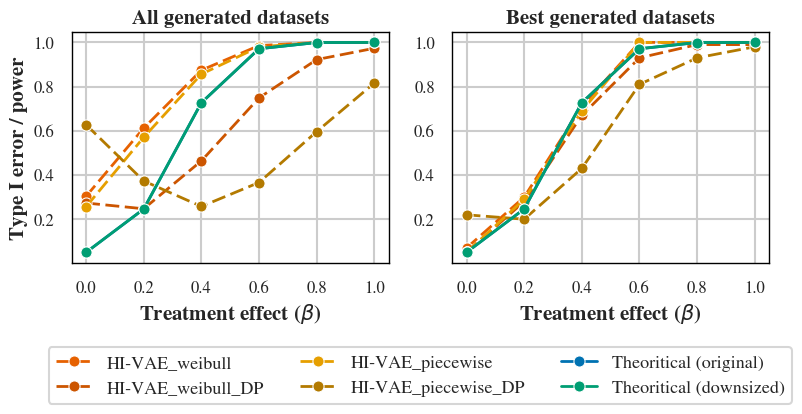

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(4.5 * 2, 3))
plt.subplots_adjust(hspace=.35, wspace=0.2)  

palette.update({'HI-VAE_weibull_DP' : "#CC5500",  
           'HI-VAE_piecewise_DP' : "#B37A00",})

custom_dashes.update({'HI-VAE_weibull_DP' : (5,2), 
                      'HI-VAE_piecewise_DP' : (5,2),})


results_control = results_control_indep.copy(deep=True)

# ALL datasets 
i = 0
df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
for spine in axs[i].spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
results_ext_control = results_control[results_control.aug_perc == aug_percs[-1]].copy(deep=True)
H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []

for generator_name in generators_sel:
    if "DP" in generator_name:
        results_control_indep_DP["reject_H0_gen_" + generator_name] = results_control_indep_DP['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_control_indep_DP.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])
    else:
        results_ext_control["reject_H0_gen_" + generator_name] = results_ext_control['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_ext_control.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

power_theo = []
power_theo_init = []
for j in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                columns=["Learner", "Treatment effect", "Power"])])

df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                columns=["Learner", "Treatment effect", "Power"])])

df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                    linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
axs[i].set_ylabel("")
axs[0].set_ylabel("Level / power", fontweight="semibold", fontsize=15)
axs[i].set_xlabel("")
axs[i].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
axs[i].set_title('All generated datasets', fontweight="semibold", fontsize=15)
axs[i].legend().remove()
axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
axs[i].tick_params(axis='x', labelsize=12)
axs[i].tick_params(axis='y', labelsize=12)


df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
for spine in axs[i].spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
results_ext_control = results_control[results_control.aug_perc == aug_percs[-1]].copy(deep=True)
H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()

# best generated dataset
i = 1
for spine in axs[i].spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
for generator_name in generators_sel:
    if "DP" in generator_name:
        XP_num = np.unique(results_control_indep_DP["XP_num"].values)
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_control_indep_DP[results_control_indep_DP["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])
    else:
        XP_num = np.unique(results_ext_control["XP_num"].values)
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

power_theo = []
power_theo_init = []
for j in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    power_theo_init.append(cpower(D_control_theo[j] * aug_perc, D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (original)"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                columns=["Learner", "Treatment effect", "Power"])])

df = pd.concat([df, pd.DataFrame(np.array([["Theoritical (downsized)"] * len(power_theo), treat_effects_control, np.array(power_theo_init)]).T, 
                                columns=["Learner", "Treatment effect", "Power"])])

df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                    linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
axs[i].set_ylabel("")
axs[0].set_ylabel("Type I error / power", fontweight="semibold", fontsize=15)
axs[i].set_xlabel("")
axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
axs[i].set_title('Best generated datasets', fontweight="semibold", fontsize=15)
axs[i].legend().remove()
axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
axs[i].tick_params(axis='x', labelsize=12)
axs[i].tick_params(axis='y', labelsize=12)


plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.1, -.65), fontsize=13)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_DP", bbox_inches="tight")
plt.show()

- ### Synthcity metrics boxplots

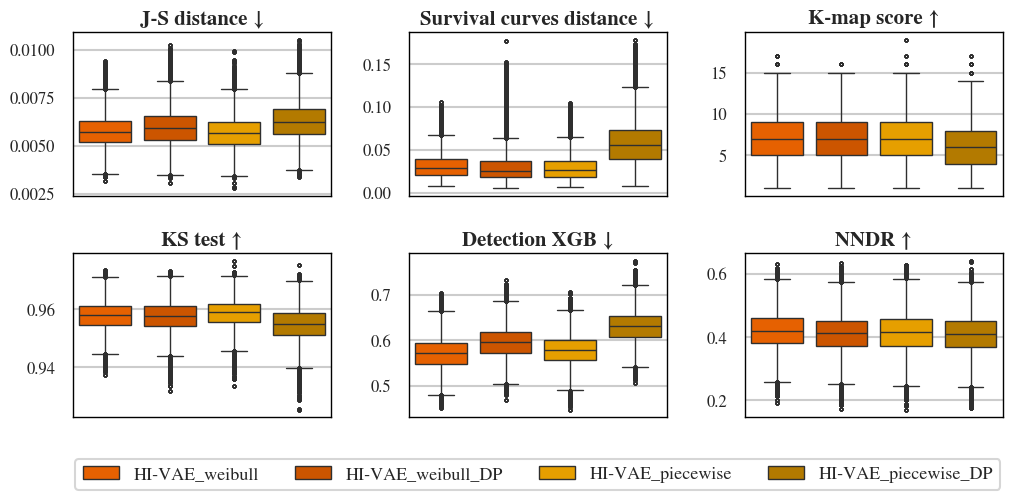

In [25]:
metrics=[[['J-S distance', "min"], 
         ['Survival curves distance', "min"], 
         ['K-map score', "max"]], 
         [['KS test', "max"], 
         ['Detection XGB', "min"], 
         ['NNDR', "max"]]]

#### SYNTHCITY METRICS
num_metrics = len(metrics[0])
n_learners = len(generators_sel)


fig, axs_ = plt.subplots(2, num_metrics, figsize=(4 * 3, 2.5 * 2))
plt.subplots_adjust(hspace=.35, wspace=0.3) 


for i in range(2):
    for j, ax in enumerate(axs_[i]):
        # Format axis spines
        metric_name, opt = metrics[i][j]
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

        metric_df = pd.DataFrame()
            
       
        results_ext_control = results_control[results_control.aug_perc == aug_percs[-1]].copy(deep=True)
        k = 0
        for generator_name in generators_sel:
            if "DP" in generator_name:
                metric_df = pd.concat([metric_df, 
                                pd.DataFrame(np.array([[generator_name] * results_control_indep_DP.shape[0],   [i+j+k] * results_control_indep_DP.shape[0], 
                                                        results_control_indep_DP[metric_name + "_" + generator_name].values.astype(float)]
                                                        ).T,
                                                columns=['generator', "xpos", metric_name])])
            else:
                metric_df = pd.concat([metric_df, 
                                pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0], [i+j+k] * results_ext_control.shape[0], 
                                                        results_ext_control[metric_name + "_" + generator_name].values.astype(float)]
                                                        ).T,
                                                columns=['generator', "xpos",  metric_name])])
            k += 1
        
        metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")

        sns.boxplot(data=metric_df, 
                x="xpos", 
                y=metric_name, 
                hue="generator", 
                ax=ax, 
                palette=palette,
                showcaps=True,
                fliersize=2, 
                linewidth=1, 
                saturation=1)

        ax.set_xticks([])     
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel('')

        if opt == "max":
            ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
        else:
            ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")

        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend().remove()


fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.8, -.5), fontsize=13)
plt.savefig("../figures/datasets_perf_DP", bbox_inches="tight")
plt.show()
